## Analysis of TE data (SLiM) from Horvath _et al_ 2022 

In [2]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
import itertools as it
import dadi 
import dadi.DFE as DFE
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *
import os

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [7]:
## reading in the data
# os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
# snpdat = np.genfromtxt("outfiles/SNP_generation_5000_neg_sel_s_0.005_bottleneck_run_number_1.out.txt",delimiter=',',skip_header=1,skip_footer=1)

# plt.scatter(snpdat[:,1]+1,snpdat[:,2]*1000,alpha=0.5); plt.loglog();
# plt.hist(snpdat[:,2]*1000,25)
# fs = moments.Spectrum(np.histogram(snpdat[:,2]*1000,bins=range(0,1002))[0])
# for g in np.linspace(0,1,10):
#     print(g)
#     print(get_ll_freqconstantTE(g,{'sfs':fs,'theta':5e4,'p_misid':0},1000))

### Joint estimation of mutation rate $\theta$ & selection coefficient $\gamma$ from a constant population size

In [57]:
## simulate the data, simple: single gamma, single theta 
fsa = run_mom_iterate_constant(10000, 200, -10/10000, 10000, 100, {})
fsa[fsa<0] = -fsa[fsa<0]

mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
SMS = np.zeros_like(fsa)
for i in range(1,SMS.shape[0]):
    for j in range(1,SMS.shape[1]):
        SMS[i,j] = rng.poisson(fsa[-i,j],1)
SMSmask = np.ma.array(SMS,mask=mask)

In [41]:
# -10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':500,'N':10000,'p_misid':0,'gens':10000},200)).x
# get_ll_thetaconstant(np.log10([10,500]),{'sms':SMSmask,'N':10000,'gens':10000},200)
# nsims = 15
estpar = np.zeros((nsims,2))
for n in range(nsims):
    SMS = np.zeros_like(fsa)
    for i in range(1,SMS.shape[0]):
        for j in range(1,SMS.shape[1]):
            SMS[i,j] = rng.poisson(fsa[-i,j],1)
    SMSmask = np.ma.array(SMS,mask=mask)

    tempres = sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,10]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))
    estpar[n,0] = -10**tempres.x[0]
    estpar[n,1] = 10**tempres.x[1]
    print(estpar[n,])
# sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,100]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))

[-1.268 102.273]
[-0.322 94.504]
[-0.439 100.153]
[-1.614 96.826]
[-0.522 96.128]
[-1.450 105.270]
[-1.304 113.876]
[-1.354 102.682]
[-0.001 80.998]
[-1.320 100.208]
[-1.429 106.364]
[-0.458 95.338]
[-0.922 97.367]
[-1.476 104.501]
[-1.100 91.161]


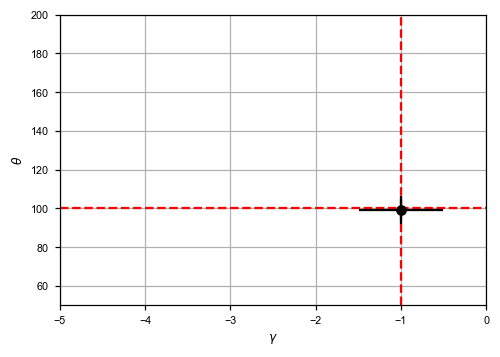

In [44]:
plt.axvline(-1,color='red',ls='--'); plt.axhline(100,color='red',ls='--'); plt.grid(); plt.ylim((50,200))
plt.errorbar(np.mean(estpar[:,0]),np.mean(estpar[:,1]),xerr=np.std(estpar[:,0]),yerr=np.std(estpar[:,1]),fmt='ko'); plt.xlabel(r'$\gamma$'); plt.ylabel(r'$\theta$'); plt.xlim((-5,0));

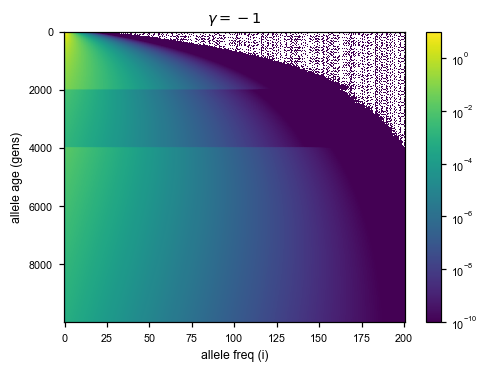

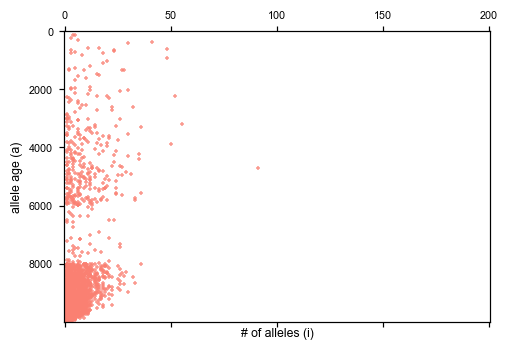

In [77]:
## simulate data for slightly more complex scenario: single gamma, bottleneck theta with **GIVEN** changepoints
# need a way to manipulate the run_mom_iterate internal values (using a specific theta model)
# plot what the expected fsa & SMSmask look like (do 10x increase)
theta = np.repeat(2000,10000); theta[2000:4000] = 200
fsa = run_mom_iterate_theta(10000, 200, -10/10000, 10000, theta, {})
plt.imshow(fsa[::-1], aspect='auto', norm=colors.LogNorm(vmin=1e-10)); plt.title(r'$\gamma = -1$'); plt.xlabel('allele freq (i)'); plt.ylabel('allele age (gens)'); plt.colorbar(); plt.show()
mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
SMS = np.zeros_like(fsa)
for i in range(1,SMS.shape[0]):
    for j in range(1,SMS.shape[1]):
        SMS[i,j] = rng.poisson(fsa[-i,j],1)
SMSmask = np.ma.array(SMS,mask=mask)
plt.spy(SMSmask[::-1],aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()

In [204]:
sp.optimize.minimize(get_ll_theta_bottleneck,x0=np.log10([10,5,20]),method='L-BFGS-B',args=({'sms':SMSmask,'N':10000,'gens':10000,'changept1':2000,'changept2':4000},200),bounds=((-3,3),(0,4),(0,4)))
# np.sqrt(np.diag(B.hess_inv.todense()))
get_ll_theta_bottleneck(np.log10([1,250,5000]),{'sms':SMSmask,'N':10000,'gens':10000,'changept1':200,'changept2':400})

      fun: 2438.4940795750167
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.870, 2.328, -2.583])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 92
      nit: 8
     njev: 23
   status: 0
  success: True
        x: array([-0.195, 2.041, 1.629])

In [ ]:
# def optim_func(x0):
#     return sp.optimize.minimize(get_ll_theta_bottleneck,x0=x0,method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-1,3),(0,4),(0,4),(0,4),(1,4)))
# get_ll_theta_bottleneck(np.log10([10,2000,200,2000,2000]),{'sms':SMSmask,'N':10000,'gens':10000})
# x_init = np.vstack((np.random.uniform(0,2,6), np.random.uniform(2,4,6), np.random.uniform(1,3,6), np.random.uniform(2,4,6), np.random.uniform(1,4,6)))
# finalres = Parallel(n_jobs=2)(delayed(optim_func)(x) for x in x_init[:,:2].T)
# sp.optimize.minimize(get_ll_theta_bottleneck,x0=[1,3,2,3,3],method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-1,3),(0,4),(0,4),(0,4),(1,4)))
# estpar = np.zeros((nsims,4))
# for n in range(nsims):
#     SMS = np.zeros_like(fsa)
#     for i in range(1,SMS.shape[0]):
#         for j in range(1,SMS.shape[1]):
#             SMS[i,j] = rng.poisson(fsa[-i,j],1)
#     SMSmask = np.ma.array(SMS,mask=mask)

#     x_init = np.vstack((np.random.uniform(0,2,6), np.random.uniform(2,4,6), np.random.uniform(1,3,6), np.random.uniform(2,4,6)))
#     finalres = Parallel(n_jobs=6)(delayed(optim_func)(x) for x in x_init.T)
#     estpar[n,] = 10**finalres[np.argmin([i.fun for i in finalres])].x
#     print(estpar[n,])

In [494]:
## simulate data for slightly more complex scenario: single gamma, two epoch theta with unknown changepoint
# theta = np.repeat(2000,10000); theta[4000:] = 200
# fsa = run_mom_iterate_theta(10000, 200, -1/10000, 10000, theta, {})
# plt.imshow(fsa, aspect='auto', norm=colors.LogNorm(vmin=1e-10)); plt.grid(); plt.title(r'$\gamma = -5$'); plt.xlabel('allele freq (i)'); plt.ylabel('allele age (gens)'); plt.colorbar(); plt.show()
# SMS = np.zeros_like(fsa)
# mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
# for i in range(1,SMS.shape[0]):
#     for j in range(1,SMS.shape[1]):
#         SMS[i,j] = rng.poisson(fsa[-i,j],1)
# SMSmask = np.ma.array(SMS,mask=mask)
# plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8, origin='lower'); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.grid(); plt.show()
# plt.plot(theta,'grey'); plt.xlabel('gens ago (a)'); plt.ylabel(r'$\theta$'); 
# SMSmask.sum()

In [97]:
# tempres = sp.optimize.minimize(get_ll_theta_twoepoch,x0=np.log10([2,40,600,5000]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4),(0,4),(0,4)))
# get_ll_theta_twoepoch(np.log10([2,200,1000,400]),{'sms':SMSmask,'N':10000,'gens':10000})
def optim_func(x0):
    return sp.optimize.minimize(get_ll_theta_twoepoch,x0=x0,method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},50),bounds=((-3,3),(0,4),(0,4),(0,4)))
estpar = np.zeros((nsims,4))
for n in range(nsims):
    SMS = np.zeros_like(fsa)
    for i in range(1,SMS.shape[0]):
        for j in range(1,SMS.shape[1]):
            SMS[i,j] = rng.poisson(fsa[-i,j],1)
    SMSmask = np.ma.array(SMS,mask=mask)

    x_init = np.vstack((np.random.uniform(0,2,8), np.random.uniform(2,4,8), np.random.uniform(1,3,8), np.random.uniform(2,4,8)))
    finalres = Parallel(n_jobs=8)(delayed(optim_func)(x) for x in x_init.T)
    estpar[n,] = 10**finalres[np.argmin([i.fun for i in finalres])].x
    print(estpar[n,])

[4.267 1935.872 176.742 4007.919]
[4.664 1985.657 214.660 3998.000]
[5.156 2126.894 183.250 4000.427]
[5.473 2072.574 262.466 3997.041]
[5.528 2045.253 198.868 4005.612]
[5.053 2001.158 204.187 3999.672]
[5.458 2056.038 208.469 3995.861]
[6.108 2118.825 273.831 3999.000]
[4.936 1988.867 219.945 3998.312]
[4.363 1930.973 174.615 4003.916]
[4.787 2014.581 172.977 3998.121]
[5.086 1989.640 199.238 3998.183]
[5.358 2115.837 201.220 3998.001]
[4.360 1927.788 150.064 3987.875]
[4.784 2028.192 213.389 4001.167]


In [73]:
## what if we think there is only one mutation rate? 
# finalres[2].fun, sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,10]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))
# Parallel(n_jobs=4)(delayed(optim_func)(x) for x in x_init.T), sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,10]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))

([<matplotlib.axis.XTick at 0x1459335e0>,
 [Text(1, 0, '$|\\gamma|$'),
  Text(2, 0, '$\\theta_1$'),
  Text(3, 0, '$\\theta_2$'),
  Text(4, 0, 'changepoint')])

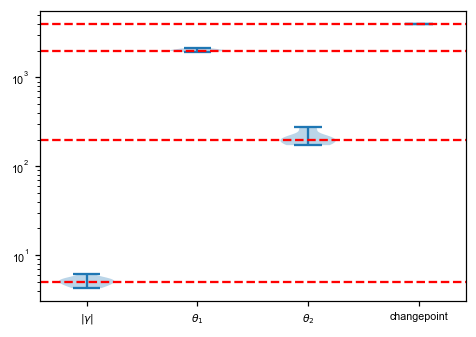

In [108]:
# estpar[10,] = [9.859, 2048.652, 195.156, 3989.037]
plt.violinplot(estpar[:11,]); plt.semilogy(); plt.axhline(5,color='red',ls='--'); plt.axhline(2000,color='red',ls='--'); plt.axhline(200,color='red',ls='--'); plt.axhline(4000,color='red',ls='--'); plt.xticks(range(1,5),labels=[r'$|\gamma|$',r'$\theta_1$',r'$\theta_2$','changepoint']) 
# plt.plot(range(51),SMSmask.sum(axis=0),'ko'); plt.loglog()
# np.percentile(estpar,[5,95],axis=0)
# sp.optimize.minimize(get_ll_theta_twoepoch,x0=[1.5,3.5,1.6,3],method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4),(0,4),(0,4)))
# from joblib import Parallel, delayed
# finalres = Parallel(n_jobs=6)(delayed(my_func)(x) for x in x_init.T)
# 10**finalres[np.argmin([i.fun for i in finalres])].x

## Reading in TE data from Stitzer et al, 2021

The *te_ages_eightfams_nonascertained.txt* file contains 32 columns - 1:4 summarize the locus, 5 is the family identifier, 6:30 contain the age estimate for each allele, which sometimes I refer to as k2p age (the column names are variety names of different maize genotypes). The column has NA if that individual doesn't have a TE at that locus. Column 31 is the allele count from this sample of 26, and column 32 is the mean age across individuals with the allele. 

Looks like on average older alleles are higher in frequency, though there are a few very old alleles in the singleton and doubleton bins (potential genotyping errors)

26.932968749999997
65.5296875
120.84124999999999
200.1065625
313.7
476.48437499999994
709.765625
1044.075
1523.159375
2209.7187499999995
3193.59375
4603.59375
6624.15625
9519.8125
13669.437499999998
19616.124999999996
28138.156249999996
40350.625
57852.18749999999
82932.8125
118875.3125
170383.12499999997
244196.87499999997
349978.125
501568.75
718806.2499999999
1030121.8749999999
1476262.5
2115606.25


Text(0.5, 1.0, 'Maize Chr1')

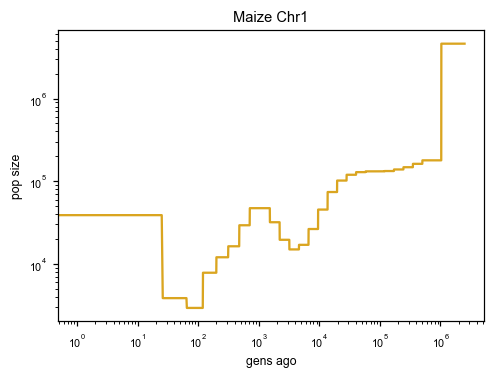

In [3]:
tedata = pd.read_csv("TEstuff/te_ages_eightfams_nonascertained.txt",sep='\t',header=0)

dem=pd.read_csv("TEstuff/nam.1.noouts.final.txt",delimiter='\t')

demogen = np.zeros(int(2.5e6))
for i in range(30):
    if i==29:
        endpt = len(demogen)
    else:
        endpt = dem['right_time_boundary'][i]/3.2e-8
        print(endpt)
    demogen[range(int(dem['left_time_boundary'][i]/3.2e-8),int(endpt))] = (1/dem['lambda'][i])/6.4e-8

plt.plot(demogen,'goldenrod'); plt.loglog(); plt.xlabel('gens ago'); plt.ylabel('pop size'); plt.title('Maize Chr1')

In [537]:
# ['RLC00002', 'RLC00004', 'RLC00030', 'RLC00032', 'RLG00001', 'RLG00003', 'RLG00008', 'RLG00011']
# [125, 178, 109, 127, 1214, 144, 118, 120]

# plt.hist(tedata.iloc[np.where(tedata['fam']=='RLC00030')[0],-1]*1e6); #plt.hist(tedata.iloc[np.where(tedata['fam']=='RLC00002')[0],-1]/2/3.2e-8,15,color='grey',alpha=0.6)

127

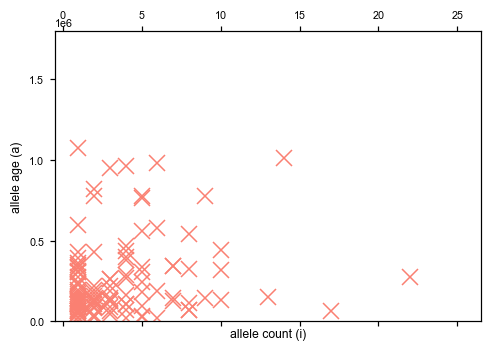

In [34]:
# plt.hist(tedata.loc[tedata['fam']=='RLC00032','allelecount'],bins=range(1,26),color='grey'); plt.xlabel('allele count'); plt.title('RLC00032')
# plt.hist(tedata.loc[tedata['fam']=='RLC00032','meanage']*1e6,15); plt.xlabel('mean k2p age (gens?)'); plt.title('RLC00032')

# sfs = moments.Spectrum(np.histogram(tedata.loc[tedata['fam']=='RLC00032','allelecount'],bins=range(0,28))[0])
# moments.Plotting.plot_1d_fs(sfs); plt.show()

mask = np.zeros((2500000,26+1),dtype='int16'); 
mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
SMS = np.zeros_like(mask) #sp.sparse.coo_array((1230850,26+1),dtype='int16')
for i in np.where(tedata['fam']=='RLG00011')[0]:
    if(tedata.iloc[i,-1]==0):
        SMS[1,tedata.iloc[i,-2]] += 1
    elif(tedata.iloc[i,-1]/2/3.2e-8<2500000):
    # else:
        SMS[int(tedata.iloc[i,-1]/2/3.2e-8),tedata.iloc[i,-2]] += 1
SMSmask = np.ma.array(SMS,mask=mask)

plt.spy(SMSmask,aspect='auto',color='salmon',marker='x'); plt.ylim((-1000,1800000)); plt.xlabel('allele count (i)'); plt.ylabel('allele age (a)'); plt.show()

In [22]:
## MLE with freq alone gives gamma ~ -20 & theta ~ 200
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':500,'p_misid':0},26),bracket=(-2,3),options={'maxiter':20})
# get_ll_freqconstant(np.log10(15),{'sfs':sfs,'theta':200,'p_misid':0},26) 
# print(sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,100]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':80000},26),bounds=((-3,3),(0,4))))
get_ll_thetaconstant(np.log10([10,100]),{'sms':SMSmask,'N':10000,'gens':1800000},26)
# print(sp.optimize.minimize(get_ll_thetaconstant_freq,x0=np.log10([10,100]),method='Nelder-Mead',args=({'sfs':sfs},26),bounds=((-3,3),(0,4))))
# get_ll_thetaconstant_freq(np.log10([10,100]),{'sfs':sfs,},26)
## ll = -1618 with gamma = -2.65 & theta = 63 for RLC00032 --> doesn't converge for more complex models
## ll = -1491 with gamma = -2.24 & theta = 80 for RLC00004
## ll = -1118 with gamma = -1.35 & theta = 45 for RLC00002
## ll = -1245 with gamma = -1.32 & theta = 38 for RLC00030
## ll = -1430 with gamma = -0.38 & theta = 40 for RLG00003
## ll = -1200 with gamma = -0.65 & theta = 37 for RLG00008

# sp.optimize.minimize(get_ll_theta_twoepoch,x0=np.log10([3,10,100,1000]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':80000},26),bounds=((-3,3),(0,4),(0,4),(2,5)))
# get_ll_theta_twoepoch(np.log10([1.73,66,60,1500]),{'sms':SMSmask,'N':10000,'gens':80000},26)
# def optim_func_te(x0):
#     return sp.optimize.minimize(get_ll_theta_twoepoch,x0=x0,method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':80000},26),bounds=((-3,3),(0,4),(0,4),(2,4.9)))
# x_init_te = np.vstack((np.random.uniform(-2,2,6), np.random.uniform(0,4,6), np.random.uniform(0,4,6), np.random.uniform(2,5,6)))
# finalres_te = Parallel(n_jobs=6)(delayed(optim_func)(x) for x in x_init_te.T)
# print(finalres_te[np.argmin([i.fun for i in finalres_te])])
## ll = -1475 with gamma = -2.65 & theta1 = 7, theta2 = 106, changept = 780 for RLC00004 *
## ll = -1113 with gamma = -1.73 & theta1 = 26, theta2 = 60, changept = 1490 for RLC00002 
## ll = -1355 with gamma = -1.64 & theta1 = 11, theta2 = 168, changept = 10590 for RLG00003 *
## ll = -1180 with gamma = -0.83 & theta1 = 7.3, theta2 = 50, changept = 2100 for RLG00008 

# sp.optimize.minimize(get_ll_theta_bottleneck,x0=np.log10([2.18,130,40,112,15000]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':80000},26),bounds=((-3,3),(0,4),(0,4),(2,4.8),(1.8,4.5)))
# def optim_func_bn(x0):
#     return sp.optimize.minimize(get_ll_theta_bottleneck,x0=x0,method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':80000},26),bounds=((-3,3),(0,4),(0,4),(2,4.8),(1.8,4.2)))
# x_init_bn = np.vstack((np.random.uniform(-2,2,6), np.random.uniform(0,4,6), np.random.uniform(0,4,6), np.random.uniform(2,5,6), np.random.uniform(2,4,6)))
# finalres_bn = Parallel(n_jobs=6)(delayed(optim_func_bn)(x) for x in x_init_bn.T)
# print(finalres_bn[np.argmin([i.fun for i in finalres_bn])])
## ll = -1484 with gamma = -1.06 & theta1 = 68, theta2 = 1, changept = 100, dur = 678 for RLC00004
## ll = -1106 with gamma = -2.22 & theta1 = 138, theta2 = 40, changept = 100, dur = 15848 for RLC00002 *
## ll = -1372 with gamma = -1.46 & theta1 = 130, theta2 = 13, changept = 186, dur = 10000 for RLG00003 
## ll = -1170 with gamma = -1.95 & theta1 = 125, theta2 = 22, changept = 102, dur = 10000 for RLG00008 * 

8359.201

In [504]:
# plt.plot(demogen/100000); plt.loglog()
# USE NON-CONSTANT DEMOGRAPHY IN FITTING GAMMA AND MUT RATES
demogen[:100000]

array([38846.610, 38846.610, 38846.610, ..., 131749.806, 131749.806,
       131749.806])

In [557]:
# def create_bottleneck_vec(theta1, theta2, changept, dur, tot):
#     mutrates = np.zeros(tot)
#     mutrates[:int(changept)] = theta1; mutrates[int(changept):int(changept+dur)] = theta2
#     mutrates[int(changept+dur):] = theta1
#     return mutrates

# def create_twoepoch_vec(theta1, theta2, changept, tot):
#     mutrates = np.zeros(tot)
#     mutrates[:int(changept)] = theta1
#     mutrates[int(changept):] = theta2
#     return mutrates

# plt.plot(create_twoepoch_vec(7,106,780,80000),label=r'RLC00004, $\gamma=-2.65$'); plt.plot(create_twoepoch_vec(11,168,10590,80000),label=r'RLG00003, $\gamma=-1.64$')
# plt.plot(create_bottleneck_vec(138,40,100,15848,80000),label=r'RLC00002, $\gamma=-2.22$'); plt.plot(create_bottleneck_vec(125,22,102,10000,80000),label=r'RLG00008, $\gamma=-1.95$')
# plt.xlabel('gens ago'); plt.ylabel(r'$\theta$'); plt.loglog(); plt.legend(loc='lower right',fontsize='small')

In [35]:
## changing popsize incorporated here:
## plt.plot(demogen[:80000],'--',color='goldenrod',label='scaled Ne'); plt.semilogx()
# get_ll_thetaconstant_changing(np.log10([5,500]),{'sms':SMSmask,'Nc':demogen[:1800000][::-1]},26)
sp.optimize.minimize(get_ll_thetaconstant_changing,x0=np.log10([5,50]),method='Nelder-Mead',args=({'sms':SMSmask,'Nc':demogen[::-1]},26),bounds=((-3,3),(0,4)))
## ll = -1647 with gamma = -2.57 & theta = 118 for RLC00032
## ll = -2526 with gamma = -5.31 & theta = 240 for RLC00004 (using whole data set, took ~33mins)
## ll = -17033 with gamma = -5.83 & theta = 1578 for RLG00001 (~51 mins)
## ll = -2030 with gamma = -0.001 & theta = 80 for RLG00003
## ll = -1825 with gamma = -0.37 & theta = 71 for RLG00008 

# get_ll_theta_twoepoch_changing(np.log10([1.73,66,60,1500]),{'sms':SMSmask,'Nc':demogen[:80000]},26)
# sp.optimize.minimize(get_ll_theta_twoepoch_changing,x0=np.log10([3,10,100,1000]),method='Nelder-Mead',args=({'sms':SMSmask,'Nc':demogen[:80000]},26),bounds=((-3,3),(0,4),(0,4),(2,5)))
## ll = -1463 with gamma = -2.71 & theta1 = 78, theta2 = 206, changept = 1560 for RLC00004 

# sp.optimize.minimize(get_ll_theta_bottleneck_changing,x0=np.log10([3,10,100,1000,10000]),method='Nelder-Mead',args=({'sms':SMSmask,'Nc':demogen[:80000]},26),bounds=((-3,3),(0,4),(0,4),(2,4.8),(1.8,4.7)))
## ll = -1467 with gamma = -2.05 & theta1 = 28, theta2 = 155, changept = 776, dur = 39800 for RLG00004 